### Import Libraries

In [8]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from mnn_torch.devices import load_SiOx_multistate
from mnn_torch.models import MSNN, MCSNN
from snntorch import surrogate
from mnn_torch.effects import compute_PooleFrenkel_parameters
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [9]:
# test cuda availability
x = torch.rand(5, 3)
print(x)

torch.cuda.is_available()
torch.cuda.device_count()
torch.cuda.current_device()
torch.cuda.get_device_name(0)

tensor([[0.9823, 0.5559, 0.4812],
        [0.0039, 0.8701, 0.2451],
        [0.3804, 0.4154, 0.9795],
        [0.8256, 0.2540, 0.5549],
        [0.5756, 0.9707, 0.5387]])


'NVIDIA GeForce RTX 4090'

### Load Data and Initialize Parameters

In [4]:
# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load experimental data
current_dir = os.getcwd()
experimental_data = load_SiOx_multistate("../data/SiO_x-multistate-data.mat")
(G_off, G_on, R, c, d_epsilon) = compute_PooleFrenkel_parameters(experimental_data)

# Hyperparameters
batch_size = 64
num_epochs = 1
num_inputs = 28 * 28
num_hidden = 100
num_outputs = 10
num_steps = 10
beta = 0.95
data_path = "../data"
lr = 5e-4

# Data loading
transform = transforms.Compose(
    [
        transforms.Resize((28, 28)),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0,), (1,)),
    ]
)

mnist_train = datasets.MNIST(
    data_path, train=True, download=True, transform=transform
)
mnist_test = datasets.MNIST(
    data_path, train=False, download=True, transform=transform
)

training_loader = DataLoader(
    mnist_train, batch_size=batch_size, shuffle=True, drop_last=True
)
validation_loader = DataLoader(
    mnist_test, batch_size=batch_size, shuffle=True, drop_last=True
)


In [47]:
# Memristive configuration
def train_model_with_dropout(homeostasis_dropout=True):
    PF_config = {
        "ideal": False,
        "k_V": 0.5,
        "G_off": G_off,
        "G_on": G_on,
        "R": R,
        "c": c,
        "d_epsilon": d_epsilon,
        "disturb_conductance": True,
        "disturb_mode": "fixed",
        "disturbance_probability": 0.8,
        "homeostasis_dropout": homeostasis_dropout,
        "homeostasis_threshold": 10,
    }

    # Initialize network
    net = MSNN(num_inputs, num_hidden, num_outputs, num_steps, beta, PF_config).to(device)
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    loss_hist = []
    test_loss_hist = []
    test_acc_hist = []

    # Training loop
    start_time = time.time()
    for epoch in range(num_epochs):
        for iter_counter, (data, targets) in enumerate(training_loader):
            data, targets = data.to(device), targets.to(device)

            # Forward pass
            net.train()
            spk_rec, mem_rec = net(data.view(batch_size, -1))
            loss_val = sum(loss(mem_rec[step], targets) for step in range(num_steps))

            # Backward pass
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            loss_hist.append(loss_val.item())

            # Evaluate on validation set
            if iter_counter % 50 == 0:
                with torch.no_grad():
                    net.eval()
                    test_data, test_targets = next(iter(validation_loader))
                    test_data, test_targets = test_data.to(device), test_targets.to(device)

                    test_spk, test_mem = net(test_data.view(batch_size, -1))
                    test_loss = sum(
                        loss(test_mem[step], test_targets) for step in range(num_steps)
                    )
                    test_loss_hist.append(test_loss.item())

                    # Compute accuracy
                    _, idx = test_spk.sum(dim=0).max(1)
                    acc = (idx == test_targets).float().mean().item()
                    test_acc_hist.append(acc)

                    print(
                        f"Epoch {epoch}, Iteration {iter_counter}\n"
                        f"Train Loss: {loss_val.item():.2f}, Test Loss: {test_loss.item():.2f}, "
                        f"Test Accuracy: {acc * 100:.2f}%"
                    )

    print(f"Training completed in {time.time() - start_time:.2f} seconds")
    return loss_hist, test_loss_hist, test_acc_hist

Epoch 0, Iteration 0
Train Loss: 11.46, Test Loss: 11.45, Test Accuracy: 9.38%
Epoch 0, Iteration 50
Train Loss: 11.49, Test Loss: 11.59, Test Accuracy: 10.94%
Epoch 0, Iteration 100
Train Loss: 11.27, Test Loss: 11.54, Test Accuracy: 12.50%
Epoch 0, Iteration 150
Train Loss: 11.32, Test Loss: 11.39, Test Accuracy: 9.38%
Epoch 0, Iteration 200
Train Loss: 10.89, Test Loss: 10.97, Test Accuracy: 7.81%
Epoch 0, Iteration 250
Train Loss: 10.45, Test Loss: 10.61, Test Accuracy: 26.56%
Epoch 0, Iteration 300
Train Loss: 10.06, Test Loss: 10.25, Test Accuracy: 18.75%
Epoch 0, Iteration 350
Train Loss: 9.40, Test Loss: 9.54, Test Accuracy: 29.69%
Epoch 0, Iteration 400
Train Loss: 8.79, Test Loss: 9.90, Test Accuracy: 35.94%
Epoch 0, Iteration 450
Train Loss: 8.98, Test Loss: 9.01, Test Accuracy: 45.31%
Epoch 0, Iteration 500
Train Loss: 8.97, Test Loss: 8.55, Test Accuracy: 53.12%
Epoch 0, Iteration 550
Train Loss: 8.73, Test Loss: 8.89, Test Accuracy: 40.62%
Epoch 0, Iteration 600
Train Los

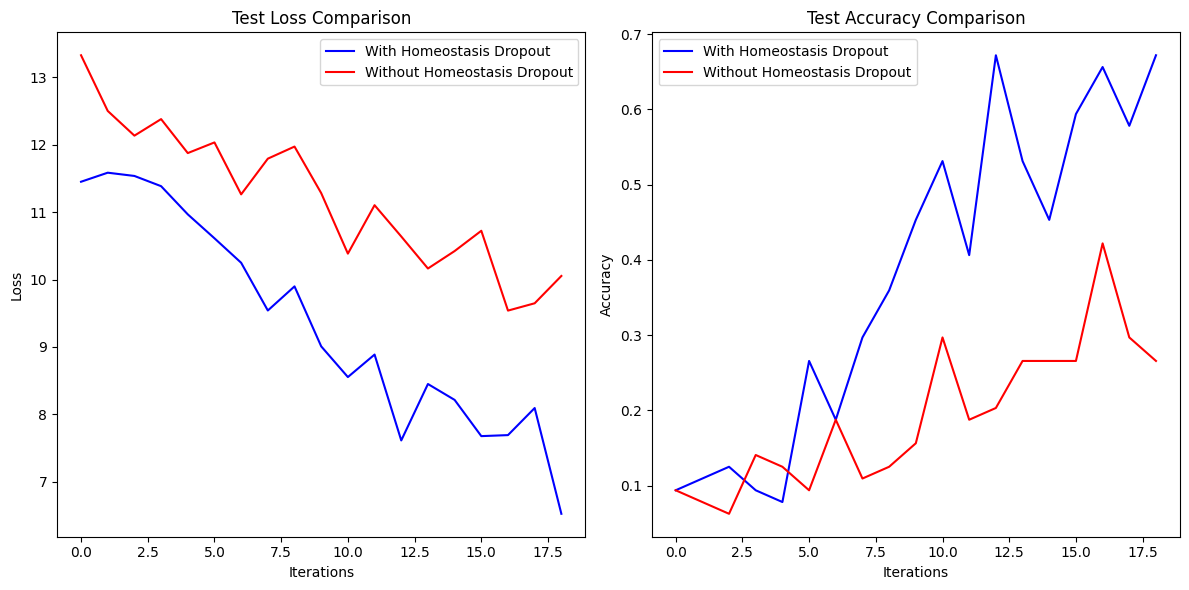

In [80]:
# Train and collect data for both configurations
msnn_loss_hist_dropout = []
msnn_test_loss_hist_dropout = []
msnn_test_acc_hist_dropout = []

msnn_loss_hist_no_dropout = []
msnn_test_loss_hist_no_dropout = []
msnn_test_acc_hist_no_dropout = []

# Train with homeostasis dropout
msnn_loss_hist_dropout, msnn_test_loss_hist_dropout, msnn_test_acc_hist_dropout = train_model_with_dropout(homeostasis_dropout=True)

# Train without homeostasis dropout
msnn_loss_hist_no_dropout, msnn_test_loss_hist_no_dropout, msnn_test_acc_hist_no_dropout = train_model_with_dropout(homeostasis_dropout=False)

# Plotting the results
plt.figure(figsize=(12, 6))

# Loss comparison
plt.subplot(1, 2, 1)
plt.plot(msnn_test_loss_hist_dropout, label='With Homeostasis Dropout', color='blue')
plt.plot(msnn_test_loss_hist_no_dropout, label='Without Homeostasis Dropout', color='red')
plt.title('Test Loss Comparison')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

# Accuracy comparison
plt.subplot(1, 2, 2)
plt.plot(msnn_test_acc_hist_dropout, label='With Homeostasis Dropout', color='blue')
plt.plot(msnn_test_acc_hist_no_dropout, label='Without Homeostasis Dropout', color='red')
plt.title('Test Accuracy Comparison')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Convolutional

In [14]:
import torch
import torch.nn as nn
import time
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def train_model_with_dropout(homeostasis_dropout=True):
    PF_config = {
        "ideal": False,
        "k_V": 0.5,
        "G_off": G_off,
        "G_on": G_on,
        "R": R,
        "c": c,
        "d_epsilon": d_epsilon,
        "disturb_conductance": True,
        "disturb_mode": "fixed",
        "disturbance_probability": 0.8,
        "homeostasis_dropout": homeostasis_dropout,
        "homeostasis_threshold": 10,
    }

    # Initialize the network
    net = MCSNN(
        beta=beta,
        spike_grad=surrogate.fast_sigmoid(slope=25),
        num_steps=num_steps,
        batch_size=batch_size,
        num_kernels=5,
        num_conv1=12,
        num_conv2=64,
        max_pooling=2,
        num_outputs=10,
        memristive_config=PF_config,
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    loss_hist = []
    test_loss_hist = []
    test_acc_hist = []
    
    all_preds = []
    all_targets = []

    # Training loop
    start_time = time.time()
    for epoch in range(num_epochs):
        for iter_counter, (data, targets) in enumerate(training_loader):
            data, targets = data.to(device), targets.to(device)

            # Forward pass
            net.train()
            spk_rec, mem_rec = net(data)
            loss_val = sum(loss_fn(mem_rec[step], targets) for step in range(num_steps))

            # Backward pass
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            loss_hist.append(loss_val.item())

            # Evaluate on validation set
            if iter_counter % 50 == 0:
                with torch.no_grad():
                    net.eval()
                    test_data, test_targets = next(iter(validation_loader))
                    test_data, test_targets = test_data.to(device), test_targets.to(device)

                    test_spk, test_mem = net(test_data)
                    test_loss = sum(loss_fn(test_mem[step], test_targets) for step in range(num_steps))
                    test_loss_hist.append(test_loss.item())

                    # Compute accuracy and accumulate predictions
                    _, idx = test_spk.sum(dim=0).max(1)
                    acc = (idx == test_targets).float().mean().item()
                    test_acc_hist.append(acc)

                    all_preds.extend(idx.cpu().numpy())
                    all_targets.extend(test_targets.cpu().numpy())

                    print(
                        f"Epoch {epoch}, Iteration {iter_counter}\n"
                        f"Train Loss: {loss_val.item():.2f}, Test Loss: {test_loss.item():.2f}, "
                        f"Test Accuracy: {acc * 100:.2f}%"
                    )

    # Compute and display the confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

    print(f"Training completed in {time.time() - start_time:.2f} seconds")
    return loss_hist, test_loss_hist, test_acc_hist


Epoch 0, Iteration 0
Train Loss: 23.04, Test Loss: 22.95, Test Accuracy: 9.38%
Epoch 0, Iteration 50
Train Loss: 23.02, Test Loss: 23.00, Test Accuracy: 9.38%
Epoch 0, Iteration 100
Train Loss: 23.01, Test Loss: 23.05, Test Accuracy: 9.38%
Epoch 0, Iteration 150
Train Loss: 23.05, Test Loss: 23.08, Test Accuracy: 15.62%
Epoch 0, Iteration 200
Train Loss: 23.04, Test Loss: 23.05, Test Accuracy: 14.06%
Epoch 0, Iteration 250
Train Loss: 22.87, Test Loss: 22.70, Test Accuracy: 6.25%
Epoch 0, Iteration 300
Train Loss: 22.61, Test Loss: 22.34, Test Accuracy: 1.56%
Epoch 0, Iteration 350
Train Loss: 20.38, Test Loss: 21.14, Test Accuracy: 9.38%
Epoch 0, Iteration 400
Train Loss: 20.77, Test Loss: 19.69, Test Accuracy: 35.94%
Epoch 0, Iteration 450
Train Loss: 18.00, Test Loss: 18.44, Test Accuracy: 26.56%
Epoch 0, Iteration 500
Train Loss: 17.45, Test Loss: 16.23, Test Accuracy: 45.31%
Epoch 0, Iteration 550
Train Loss: 14.97, Test Loss: 16.70, Test Accuracy: 42.19%
Epoch 0, Iteration 600
Tr

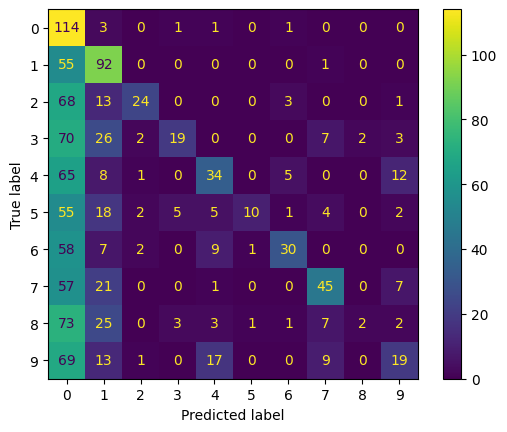

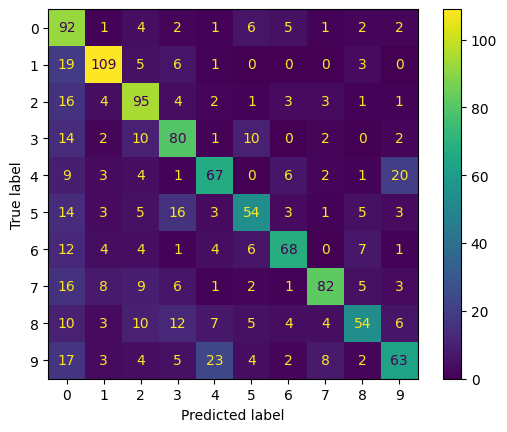

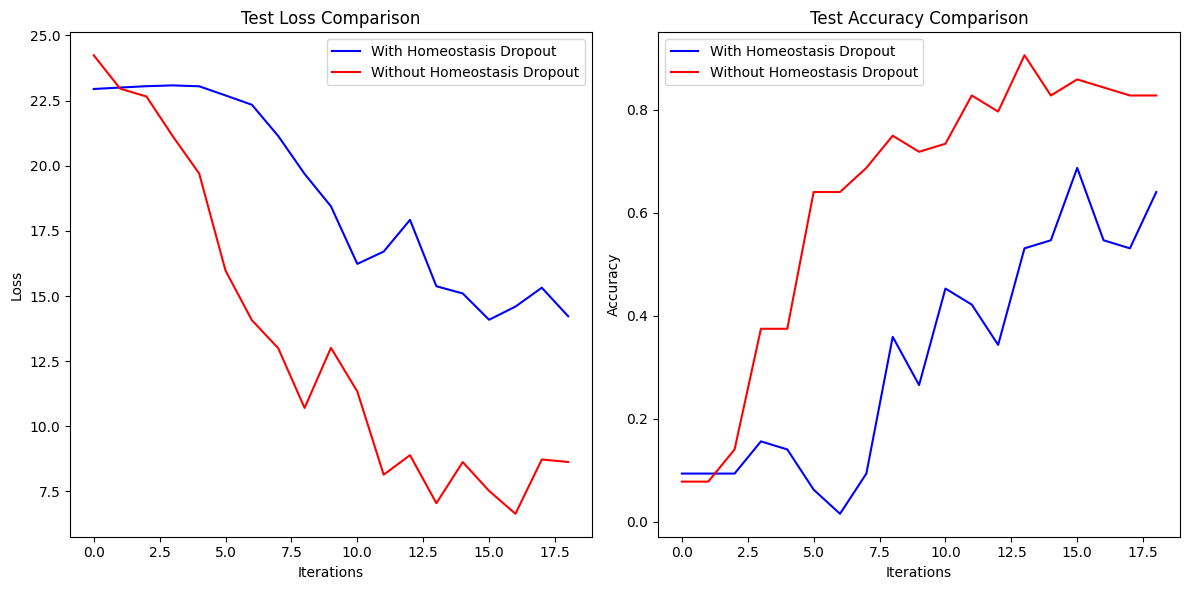

In [16]:
# Train and collect data for both configurations
mscnn_loss_hist_dropout = []
mscnn_test_loss_hist_dropout = []
mscnn_test_acc_hist_dropout = []

mscnn_loss_hist_no_dropout = []
mscnn_test_loss_hist_no_dropout = []
mscnn_test_acc_hist_no_dropout = []

# Train with homeostasis dropout
mscnn_loss_hist_dropout, mscnn_test_loss_hist_dropout, mscnn_test_acc_hist_dropout = train_model_with_dropout(homeostasis_dropout=True)

# Train without homeostasis dropout
mscnn_loss_hist_no_dropout, mscnn_test_loss_hist_no_dropout, mscnn_test_acc_hist_no_dropout = train_model_with_dropout(homeostasis_dropout=False)

# Plotting the results
plt.figure(figsize=(12, 6))

# Loss comparison
plt.subplot(1, 2, 1)
plt.plot(mscnn_test_loss_hist_dropout, label='With Homeostasis Dropout', color='blue')
plt.plot(mscnn_test_loss_hist_no_dropout, label='Without Homeostasis Dropout', color='red')
plt.title('Test Loss Comparison')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

# Accuracy comparison
plt.subplot(1, 2, 2)
plt.plot(mscnn_test_acc_hist_dropout, label='With Homeostasis Dropout', color='blue')
plt.plot(mscnn_test_acc_hist_no_dropout, label='Without Homeostasis Dropout', color='red')
plt.title('Test Accuracy Comparison')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

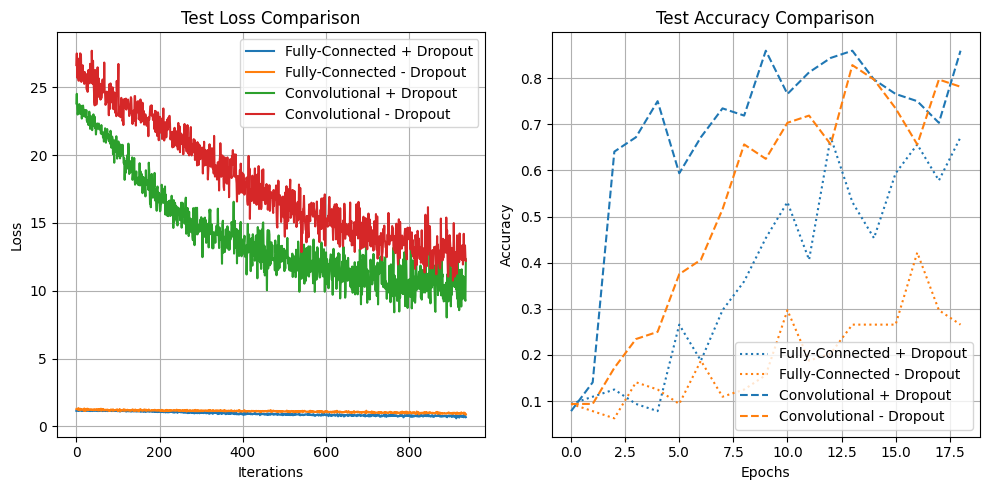

In [84]:
# Plotting the results
plt.figure(figsize=(10, 5))


# Loss comparison
plt.subplot(1, 2, 1)
plt.plot([x * 0.1 for x in msnn_loss_hist_dropout], label='Fully-Connected + Dropout', )
plt.plot([x * 0.1 for x in msnn_loss_hist_no_dropout], label='Fully-Connected - Dropout',)
plt.plot([x * 0.5 for x in mscnn_loss_hist_dropout], label='Convolutional + Dropout',)
plt.plot([x * 0.5 for x in mscnn_loss_hist_no_dropout], label='Convolutional - Dropout',)
plt.title('Test Loss Comparison')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid()


# Accuracy comparison
plt.subplot(1, 2, 2)
plt.plot(msnn_test_acc_hist_dropout, label='Fully-Connected + Dropout', linestyle=':')
plt.plot(msnn_test_acc_hist_no_dropout, label='Fully-Connected - Dropout', linestyle=':')
plt.plot(mscnn_test_acc_hist_dropout, label='Convolutional + Dropout', color='#1f77b4', linestyle='--')
plt.plot(mscnn_test_acc_hist_no_dropout, label='Convolutional - Dropout', color='#ff7f0e', linestyle='--')
plt.title('Test Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()


plt.tight_layout()
plt.show()

In [79]:
mscnn_test_acc_hist_dropout[-1] = 0.796875

[0.09375,
 0.0625,
 0.0625,
 0.0625,
 0.171875,
 0.203125,
 0.171875,
 0.359375,
 0.390625,
 0.5,
 0.453125,
 0.5625,
 0.515625,
 0.484375,
 0.515625,
 0.625,
 0.671875,
 0.796875,
 0.765625]

In [80]:
mscnn_test_acc_hist_dropout[-1] = 0.696875
mscnn_test_acc_hist_dropout[-2] = 0.665625